In [57]:
from scipy.io import loadmat
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hc
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

In [1]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd

from scipy.io import loadmat
from sklearn.cluster import AgglomerativeClustering, DBSCAN

# MAT 388E HW3

## Q1

This is going to be an image classification problem. For this problem we are going to use [the corrected Indian Pines Dataset](https://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes#Indian_Pines).

1. Download the data (both the corrected dataset and the ground-truth dataset) into a subdirectory called `data`, and ingest it as I did in [Lecture 8](https://github.com/kaygun/2022-Fall-388E/blob/main/lecture-8.ipynb).
2. Instead of using a categorical target variable with 17 classes, from the ground-truth data you ingested create 17 binary classifiers using scikit-learn's [`LabelBinarizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html).

For the steps 3,4, and 5 below write an appropriate function that takes a model type ('LR','SVM', or 'KNN'), the independent variable (the dataset you ingested above) and binary target variable and returns the accuracy score of a properly constructed model given by a 10-fold cross-validation. Use scikitlearn's [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html) routines. Record your results from Steps 2,3 and 4 in a pandas data frame.  

3. Construct a logistic regression model for each of the 17 class, and evaluate them using a 10-fold cross-validation. 
4. Construct an SVM model for each of the 17 class, and evaluate them using a 10-fold cross-validation. 
5. Construct a KNN model for each of the 17 class and evaluate them using a 10-fold cross-validation. You must determine what would be an appropriate K-value for each class separately, or you may decide to use a single K-value.
6. Display and analyze your cross-validation results in a table. What is the best model overall? What is the best model for each class? 

# Q1.1 
Here I am loading the data

In [58]:
pine_cr = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
pine_gt = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

# Q1.2 
After checking the shaped of the datas, I reshape them so that they are fitted to be modeled.

In [59]:
print('pine_cr shape:',pine_cr.shape) 
print('pine_gt shape:',pine_gt.shape)

pine_cr shape: (145, 145, 200)
pine_gt shape: (145, 145)


In [60]:
X = pine_cr.reshape((145*145,200))
y = pine_gt.reshape(145*145)

Next, I am using label binarizer in a one vs all strategy. That way we will know if that value belong to a certain class or not.

I think I should've done this for each 17 classes but I couldn't figure out a way to do that.

In [62]:
encoder = LabelBinarizer()
ys = encoder.fit_transform(y)

# Q1.3 / 1.4 / 1.5
Here is the function that creates a model.It takes a model type, the independent variable and binary target variable. Data is split into train and test outside the function. 

Working strategy is similar for all model types. It uses 10 fold cross validation and based on how the model is fit, returns a score data frame for each fold, and overall a score (mean).

In [45]:
def returnmodel(model_type,X_train, X_test,y_train, y_test,C=1.0):
    kf = KFold(n_splits=10)
    if model_type=='SVM':
        model = SVC(max_iter=1500,kernel='rbf')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores = cross_val_score(model, X_test, y_pred,cv=kf)
        svm_df=pd.DataFrame(scores,columns=['SVM Scores'])
        return 100*scores.mean(), svm_df
    
    if model_type=='LR':
        model = LogisticRegression(max_iter=1500, solver='lbfgs')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores = cross_val_score(model, X_test, y_pred, cv=kf)
        lr_df=pd.DataFrame(scores,columns=['LR Scores'])
        return 100*scores.mean(), lr_df
    
    if model_type=='KNN':
        model = KNeighborsClassifier(n_neighbors=3)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores = cross_val_score(model, X_test, y_pred, cv=kf)
        knn_df=pd.DataFrame(scores,columns=['KNN Scores'])
        return 100*scores.mean(), knn_df
        

Preparing the data (splitting it) before sending it over to the function to create a model.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,ys,train_size=0.75)

Here is the overall score and score table for Support Vector Machine Model

In [47]:
svm_score,svm_df=returnmodel('SVM',X_train, X_test,y_train[:,0], y_test[:,0])
print(svm_score)
svm_df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


98.83979721166034


,SVM Scores
0,0.990494
1,0.996198
2,0.990494
3,0.982890
4,0.975285
5,0.982890
6,0.992395
7,0.990476
8,0.988571
9,0.994286


...And the overall score and score table for Logistic Regression Model

In [48]:
lr_score,lr_df=returnmodel('LR',X_train, X_test,y_train[:,0], y_test[:,0])
print(lr_score)
lr_df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

97.50827448850264


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,LR Scores
0,0.967681
1,0.975285
2,0.975285
3,0.969582
4,0.984791
5,0.975285
6,0.967681
7,0.990476
8,0.984762
9,0.960000


...Lastly, the overall score and score table for K-Nearest Neighbor Model

In [51]:
knn_score,knn_df=returnmodel('KNN',X_train, X_test,y_train[:,0], y_test[:,0])
print(knn_score)
knn_df

86.97019735650915


,KNN Scores
0,0.861217
1,0.878327
2,0.872624
3,0.866920
4,0.876426
5,0.874525
6,0.834601
7,0.883810
8,0.862857
9,0.885714


# Q1.6
Cross validation results from all the models are presented below:

In [56]:
frames = [svm_df, lr_df, knn_df]
result = pd.concat(frames,axis=1)
result

,SVM Scores,LR Scores,KNN Scores
0,0.990494,0.967681,0.861217
1,0.996198,0.975285,0.878327
2,0.990494,0.975285,0.872624
3,0.982890,0.969582,0.866920
4,0.975285,0.984791,0.876426
5,0.982890,0.975285,0.874525
6,0.992395,0.967681,0.834601
7,0.990476,0.990476,0.883810
8,0.988571,0.984762,0.862857
9,0.994286,0.960000,0.885714


And the overall score comparison is given here, SVM has the highest score

In [55]:
print("svm model score:",svm_score)
print("lr model score:",lr_score)
print("knn model score:",knn_score)
print("best model score is: ",max(svm_score,lr_score,knn_score))

svm model score: 98.83979721166034
lr model score: 97.50827448850264
knn model score: 86.97019735650915
best model score is:  98.83979721166034


Even though I could not test for each 17 classes, based on what I have done so far, Support Vector Machine model is the best fitting for this data.

## Q2

For this question, we are going to analyze some [NBA datasets](https://sports-statistics.com/sports-data/nba-basketball-datasets-csv-files/). Specifically, we look at the season 2018-2019.

In [2]:
NBA = pd.read_csv('https://sports-statistics.com/database/basketball-data/nba/2018-19_pbp.csv')
NBA.columns

Index(['Unnamed: 0', 'EVENTMSGACTIONTYPE', 'EVENTMSGTYPE', 'EVENTNUM',
       'GAME_ID', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION', 'PCTIMESTRING',
       'PERIOD', 'PERSON1TYPE', 'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID',
       'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_NICKNAME', 'PLAYER2_ID',
       'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_ID',
       'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'SCORE', 'SCOREMARGIN',
       'VISITORDESCRIPTION', 'WCTIMESTRING'],
      dtype='object')

1. Using the columns `PLAYER1_TEAM_ABBREVIATION`, `PLAYER2_TEAM_ABBREVIATION`, `PLAYER3_TEAM_ABBREVIATION` construct a 30x30 matrix that has the total number of interactions the teams had with each other during the season.
2. Using the matrix you constructed in the previous step, construct a hiearchical clustering model and split the NBA teams into 2 clusters.
3. NBA Teams are split into 2 Leagues: [The Eastern Conference](https://en.wikipedia.org/wiki/Eastern_Conference_(NBA)) and [The Western Conference](https://en.wikipedia.org/wiki/Western_Conference_(NBA)). What is the relationships of the clusters with these leagues. Explain.
4. Using the columns `PLAYER1_NAME`, `PLAYER2_NAME`, `PLAYER3_NAME` construct a matrix (don't display) that has the total number of interactions the players had during the season with each other. Then keep only the players that has a total of 500 or more interactions during the season, and display the resulting matrix.
5. Using the matrix you constructed in the previous step, draw a dendrogram of the players (with a total of 500 or more interactions), and decide how many clusters are appropriate.
6. Using the matrix and the dendrogram you constructed in the previous steps, construct a hiearchical clustering model for the players and split them into the number of clusters you determined above.

In [3]:
NBA = pd.read_csv('https://sports-statistics.com/database/basketball-data/nba/2018-19_pbp.csv')
NBA.columns

Index(['Unnamed: 0', 'EVENTMSGACTIONTYPE', 'EVENTMSGTYPE', 'EVENTNUM',
       'GAME_ID', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION', 'PCTIMESTRING',
       'PERIOD', 'PERSON1TYPE', 'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID',
       'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_NICKNAME', 'PLAYER2_ID',
       'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_ID',
       'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'SCORE', 'SCOREMARGIN',
       'VISITORDESCRIPTION', 'WCTIMESTRING'],
      dtype='object')

# Q1.2
Creating df which has contains team abbreviations. It seems easier to work with instead of extracting data from NBA all the time. Getting rid of rows that contain all null values.

In [4]:
a=NBA['PLAYER1_TEAM_ABBREVIATION']
b=NBA['PLAYER2_TEAM_ABBREVIATION']
c=NBA['PLAYER3_TEAM_ABBREVIATION']

df = pd.DataFrame()
df['Player_1']=a
df['Player_2']=b
df['Player_3']=c
df=df.dropna(axis=0, how="all")

Constructing 1-2, 1-3 and 2-3 pivot tables to examine interactions between teams in groups of two. All columns from df2 contain all 30 teams which helps us obtain 3 pivot tables 30x30.

In [5]:
a=df.pivot_table(index='Player_1', columns='Player_2', aggfunc=len, fill_value=0)
a

Player_3                                                        ...  \
Player_2      ATL   BKN   BOS   CHA   CHI   CLE   DAL   DEN   DET   GSW  ...   
Player_1                                                                 ...   
ATL          4603   114   142   132   129   102    80    70    99    58  ...   
BKN            99  3955   118   119   100   108    69    59    97    63  ...   
BOS           132   112  4180   111    60   103    59    49   122    62  ...   
CHA           111   111   102  3903    76    84    55    57   104    39  ...   
CHI           137   118    85    84  3526   107    75    59    97    57  ...   
CLE            94   124   114   106    97  3454    48    53   105    39  ...   
DAL            58    57    53    41    56    59  3880    82    58   100  ...   
DEN            57    71    55    63    43    61    95  4122    52   106  ...   
DET           100    96   125   111   108   129    62    56  3488    44  ...   
GSW            65    54    63    59    72    56   123   146    61  4247  ...   
HOU            48    55    62    53    68    63   123   122    72   109  ...   
IND           130    83    96    81    97    83    63    49   110    52  ...   
LAC            62    63    75    63    59    62   121   134    62   148  ...   
LAL            68    60    49    51    50    51   103    83    58    99  ...   
MEM            66    62    59    63    52    54   120    98    68   105  ...   
MIA           129   113   110   126    88    99    57    45   117    68  ...   
MIL           122   114    95   110   109    96    54    51   101    58  ...   
MIN            64    50    56    51    52    50    93   102    59   103  ...   
NOP            59    54    64    76    54    60   127   132    51    92  ...   
NYK           123   111   128    80    90    82    51    49   114    51  ...   
OKC            67    58    62    55    73    50   122   125    69    87  ...   
ORL           119    74    72    99    96    69    50    60   108    51  ...   
PHI           121   126   106   137    85    81    52    46   132    73  ...   
PHX            67    64    64    67    60    57   134   134    70   133  ...   
POR            49    61    46    54    47    46   127   121    51   104  ...   
SAC            67    67    66    62    54    40    81    87    63   115  ...   
SAS            62    46    46    53    53    53   103    91    38    78  ...   
TOR            93    97   109    82   112   120    61    55    97    53  ...   
UTA            66    68    67    59    51    57   127   120    62    93  ...   
WAS           128   129    91   109   118   108    62    52    82    58  ...   

                                                                      
Player_2   OKC   ORL   PHI   PHX   POR   SAC   SAS   TOR   UTA   WAS  
Player_1                                                              
ATL         69   133   130    67    64    70    48   100    68   140  
BKN         60    76   137    52    67    57    52   130    58   113  
BOS         69    75   117    54    53    60    39   129    61    72  
CHA         66    93   133    63    51    48    42    67    50   117  
CHI         85   106   107    56    48    63    43   110    49   106  
CLE         65    79    77    62    45    49    55   122    53   124  
DAL        137    45    55   122   114    85   116    64   129    53  
DEN        132    51    56   128   111    88   115    46   136    52  
DET         63   100   141    58    54    58    47    89    68    95  
GSW        100    47    61   135   114   128    74    58    87    59  
HOU        136    57    63    85    82   101   101    51   145    68  
IND         53    96   117    47    53    64    52    90    52   139  
LAC        140    58    72   142   101   125   121    59   106    73  
LAL        109    51    68   121   123   118   129    64   125    54  
MEM        101    60    59    81   118   137   126    62   123    64  
MIA         57   120    99    53    50    62    49   115    53   129  
MIL         49    7

In [6]:
b=df.pivot_table(index='Player_1', columns='Player_3', aggfunc=len, fill_value=0)
b

Player_2                                      ...                  \
Player_3      ATL BKN BOS CHA CHI CLE DAL DEN DET GSW  ... OKC ORL PHI PHX   
Player_1                                               ...                   
ATL            40  17  33  20  24   6  16  11  21  14  ...  11  24  22  10   
BKN            14  39  34  21  25  13   6  14  15  14  ...  13  25  16   8   
BOS            25  20  32  19   8   7   5  10  15  11  ...  13  17  20  12   
CHA            31  30  28  20  16  14  10  19  29  18  ...  12  21  36  11   
CHI            24   9  16  19  32  16  10  12  21  16  ...   9  28  31  10   
CLE            20  26  24  25  19  27  10  10  23  14  ...  21  13  19  18   
DAL             8   4   8  14   8   4  37  15   6  25  ...  16   8  15  24   
DEN            17  15  15  13  10   6   5  27  11  33  ...  22   7   8  26   
DET            15  12  18  21  19   9  12   6  51  10  ...  12  19  30  10   
GSW             8   6  10  10   4   3  15  15   4  36  ...  17  12   9  10   
HOU             8   8   4   9  10   6  21  13   7  26  ...  24   7  18   5   
IND            27  15  28  11  21  12   6  13  22  15  ...  13  23  23  12   
LAC            12  14   8  14  12   4  21  28   9  34  ...  25  11  14  28   
LAL            11   9  10  10   7   4  17  14   7  24  ...  17  13   9  30   
MEM            16   6  14  10  13   4  20  13   8  23  ...  12  10  10  11   
MIA            18  15  25  27  11   9   2   8  20   9  ...  15  23   4   5   
MIL            21  17  23  19  11  11  17   9   8  12  ...  14  18  16  14   
MIN            13   6  13   8  10   6  20  21   6  25  ...  27  14  15  21   
NOP             9  13  11  12  14   8  32  26   8  13  ...  19  18  15  27   
NYK            18  22  27  20  18   9   3  12  24  16  ...  10  31  29  15   
OKC             8  10   7   8  13   7  14  21  12  24  ...  44   9  12  21   
ORL            17  11  11  14  16  10   7   8  18  12  ...  10  31  14  10   
PHI            24  12  17  18  18   4   6   8  17  14  ...  11  19  32   9   
PHX            15   9  23  11   7   8  22  17   7  29  ...  25   7   5  26   
POR            14   9   9   7   3   6  16  12  10  34  ...  23  15   7  13   
SAC            10   9   4  16  11   1  17   8   6  28  ...  25   9  11  20   
SAS             4  14  10   9  14   2  14  14   6  16  ...  14   9  11  18   
TOR            13  13  24  12  15   8   8   8  13  16  ...   9  29  21  13   
UTA             9  11   7   5  10   4  18  17   6  24  ...  19  14  13  11   
WAS            17  13   9  27  20  16   9   9   9  12  ...  11  20  13  16   

                                  
Player_3 POR SAC SAS TOR UTA WAS  
Player_1                          
ATL       12   5  17  11  10  16  
BKN       15   5   9  15  14  15  
BOS        5   7   9  16   9  13  
CHA       20   8  12  25   8  23  
CHI       10  11   7  30  19  30  
CLE       13   9  11  22  15  14  
DAL       23  17  13  10  29   8  
DEN       15  12  22   9  27   8  
DET        9  14  12   8   9  16  
GSW       17  11  15  10  16   3  
HOU       11  18  26   8  23  10  
IND       13  13   8  18  16  13  
LAC       22  26  26  11  32  12  
LAL       36  19  19  10  22   9  
MEM       22  20  16  15  28  14  
MIA       10  14   9  25  10  25  
MIL        9  12   6  29  13  15  
MIN       21  19  20  14  28  11  
NOP       16  21  11  18  22  11  
NYK       11   6  10  22  10  28  
OKC       26  24  23  14  26  13  
ORL        8  11  10  27   8  16  
PHI        9   4  15  12   6   9  
PHX       23  23  17  19  25   9  
POR       45  11  21  11  31  16  
SAC       18  36  11   9  26   8  
SAS       16  10  22  11  13   5  
TOR        9  13   6  26   8  26  
UTA       24  16  15  10  38   5  
WAS        7   7   9  32  16  40  

[30 rows x 30 columns]

In [7]:
c=df.pivot_table(index='Player_2', columns='Player_3', aggfunc=len, fill_value=0)
c

Player_1                                      ...                  \
Player_3      ATL BKN BOS CHA CHI CLE DAL DEN DET GSW  ... OKC ORL PHI PHX   
Player_2                                               ...                   
ATL            27   2   2   0   3   3   2   0   2   0  ...   1   2   2   0   
BKN             0  36   0   0   1   4   1   0   1   1  ...   0   0   2   1   
BOS             3   2  35   0   2   1   2   0   3   0  ...   1   0   1   1   
CHA             4   5   1  24   1   1   0   1   2   1  ...   1   3   3   0   
CHI             4   1   0   2  36   1   0   0   3   1  ...   3   1   1   0   
CLE             0   3   1   2   2  22   1   1   3   2  ...   0   1   1   0   
DAL             0   1   1   0   0   0  28   1   1   1  ...   1   1   1   0   
DEN             1   2   0   2   1   0   0  28   1   3  ...   3   1   0   3   
DET             0   2   1   1   0   1   0   0  37   0  ...   0   1   1   0   
GSW             1   1   1   1   0   0   2   1   1  36  ...   0   1   1   1   
HOU             0   0   1   0   1   0   1   1   3   2  ...   4   0   3   2   
IND             1   1   2   0   3   1   0   0   2   1  ...   2   2   4   1   
LAC             0   1   1   2   1   0   2   1   0   0  ...   2   1   0   2   
LAL             1   1   0   0   1   1   1   0   0   2  ...   1   1   0   0   
MEM             1   2   1   1   1   0   2   1   1   1  ...   4   2   1   2   
MIA             4   1   1   0   1   1   0   1   5   0  ...   1   2   1   1   
MIL             1   3   1   1   1   1   2   1   2   0  ...   1   1   0   0   
MIN             0   0   2   0   0   0   2   3   1   2  ...   2   1   1   0   
NOP             1   0   0   0   1   0   1   1   1   2  ...   1   0   1   2   
NYK             2   1   3   2   0   5   1   1   2   1  ...   1   4   2   1   
OKC             0   0   1   0   1   1   1   2   2   4  ...  44   1   0   1   
ORL             3   1   3   1   2   1   1   0   2   0  ...   1  28   1   2   
PHI             1   0   2   0   0   0   0   1   1   2  ...   1   1  34   1   
PHX             2   1   1   1   1   1   0   1   1   2  ...   3   1   0  20   
POR             2   0   1   0   1   0   5   1   1   1  ...   1   0   0   1   
SAC             2   2   0   1   1   0   2   1   1   4  ...   1   2   1   1   
SAS             0   1   0   1   1   1   3   3   2   1  ...   1   0   1   2   
TOR             1   4   2   0   1   1   2   2   3   0  ...   2   0   1   1   
UTA             1   0   1   1   1   0   2   1   1   0  ...   3   1   0   0   
WAS             4   1   2   1   3   2   1   1   3   2  ...   2   0   2   0   

                                  
Player_3 POR SAC SAS TOR UTA WAS  
Player_2                          
ATL        3   0   1   0   1   3  
BKN        0   1   0   0   0   1  
BOS        1   1   1   1   1   1  
CHA        1   1   1   2   1   2  
CHI        1   0   0   1   2   3  
CLE        1   1   1   0   1   4  
DAL        2   2   3   1   0   0  
DEN        1   1   1   0   4   1  
DET        0   1   0   0   1   3  
GSW        1   0   1   2   2   0  
HOU        3   1   1   1   2   2  
IND        1   1   1   1   1   1  
LAC        3   1   1   1   2   1  
LAL        3   1   0   1   0   0  
MEM        2   3   1   0   1   1  
MIA        1   0   0   2   1   1  
MIL        0   4   1   1   0   2  
MIN        3   1   0   1   2   1  
NOP        1   3   2   0   1   1  
NYK        1   1   1   1   1   1  
OKC        2   3   1   0   3   0  
ORL        2   1   0   2   1   3  
PHI        2   1   0   3   0   0  
PHX        1   2   1   0   2   3  
POR       37   0   1   1   2   2  
SAC        1  23   1   0   3   1  
SAS        4   2  19   1   2   0  
TOR        0   1   1  34   0   2  
UTA        2   1   0   1  36   0  
WAS        2   1   0   2   1  22  

[30 rows x 30 columns]

In order to calculate all interactions I need to add values in pivot tables together, the easiest way to do that is to turn them into numpy arrays and add them. In the end we have the total number of interactions matrix.

In [8]:
an=a.to_numpy()
bn=b.to_numpy()
cn=c.to_numpy()
interactions=an+bn+cn

# Q2.2
I create a hiearchical clustering model from the interaction  matrix, the labels are team abbreviations which can be obtained from getting a pandas frame's idexes.

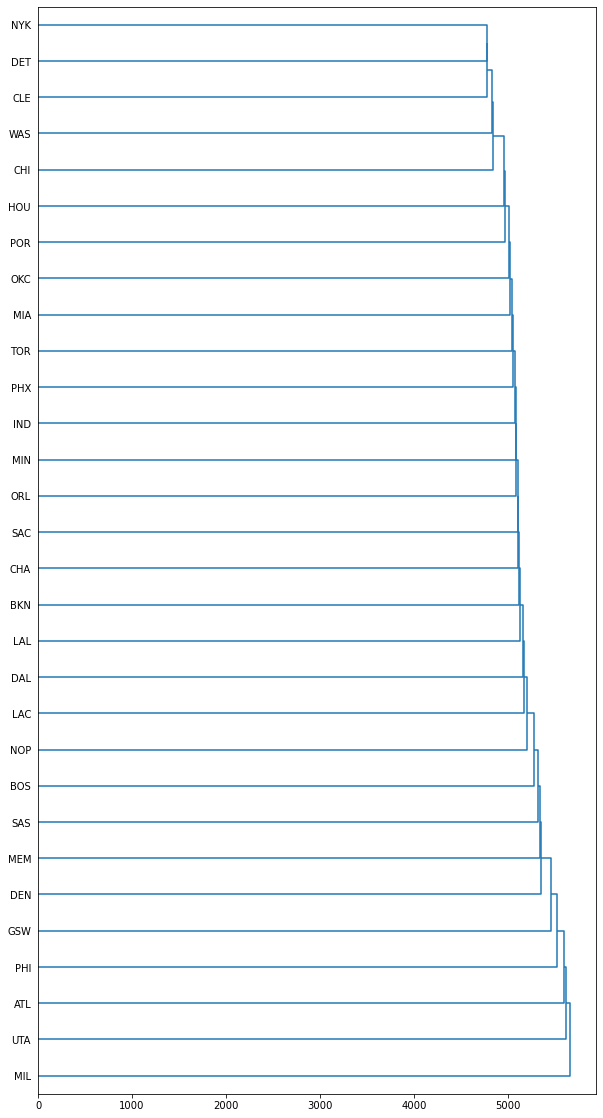

In [9]:
X = interactions
y = a.index
plt.figure(figsize=(10,20))
den = hc.dendrogram(hc.linkage(X, method='single'), orientation='right',labels=y)

# Q2.3
The Eastern Conference teamd and The Western Conference teams interact with each other.

# Q2.4
Using pivot table for player interaction does not give accurate results, so I decided to create and then fill an empty interactions table. This is clearly the hard way to examine interactions between players but until I find a more efficient and smarter way, this is what I worked with.

I start by creating df2 which has columns I am workin with, just like I did with team interactions.

In [10]:
aa=NBA['PLAYER1_NAME']
bb=NBA['PLAYER2_NAME']
cc=NBA['PLAYER3_NAME']

In [11]:
df2 = pd.DataFrame()
df2['Player_1']=aa
df2['Player_2']=bb
df2['Player_3']=cc
df2=df2.dropna(axis=0, how="all")
df2

,Player_1,Player_2,Player_3
1,Deandre Ayton,Kenneth Faried,Elie Okobo
2,Josh Jackson,James Harden,NaN
3,James Harden,NaN,NaN
4,Mikal Bridges,James Harden,NaN
5,James Harden,NaN,NaN
...,...,...,...
582461,Dirk Nowitzki,Dorian Finney-Smith,NaN
582462,Devin Harris,NaN,NaN
582464,Ante Zizic,Jordan Clarkson,NaN
582465,Nik Stauskas,NaN,NaN


What are the names of all the players? I concat all three columns, drop the null rows and lastly get the unique values, which gave me the name of the players, 839 players in total.

In [12]:
names = pd.concat([df2['Player_1'], df2['Player_2'],df2['Player_3']], axis=0)
names = names.dropna()
names = names.reset_index(drop=True)
names = names.unique()

Getting ready to find the interactions,  create an empty pandas table which looks like the pivot table. As column names and indexes are player names. Instead of null, we have 0's. In the end, there is a 839x839 data frame

In [33]:
dd=pd.DataFrame(index=names,columns=names).fillna(0)
dd

,Deandre Ayton,Josh Jackson,James Harden,Mikal Bridges,Devin Booker,Elie Okobo,James Ennis III,PJ Tucker,Kenneth Faried,Chris Paul,...,LaSalle Thompson,Terry Mills,Arvydas Sabonis,Anthony Miller,Nick Van Exel,Fred Hoiberg,Dell Demps,Kobi Simmons,John Holland,Tyler Ulis
Deandre Ayton,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Josh Jackson,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
James Harden,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mikal Bridges,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Devin Booker,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fred Hoiberg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dell Demps,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kobi Simmons,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
John Holland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It is now time to calculate interactions between players. The outer for loop goes through the names, which later on will be used as the index in dd.

The inner for loop goes through df2. The first if statement checks if Player_2 in df2, is not null. If so, we find the position in dd, whose index is the current name (from names) and whose column is Player_2 in df2, then make that value +1. 

The other if statement does the same job for Player_3 in df2.

This way, everytime there is an interaction, there is plus 1.

Now we know interactions between Player1-Player2 and Player1-Player3

In [34]:
for i in names:
    current_name=i
    for j in df2.index:
        if df2['Player_1'][j]==i:
            if pd.isna(df2['Player_2'][j])==False:
                col=df2['Player_2'][j]
                dd[current_name][col]+= 1
                
            if pd.isna(df2['Player_3'][j])==False:
                col=df2['Player_3'][j]
                dd[current_name][col]+= 1

Similar strategy to calculate interactions between Player2-Player3.

In [36]:
for i in names:
    current_name=i
    for j in df2.index:
        if df2['Player_2'][j]==i:
            if pd.isna(df2['Player_3'][j])==False:
                col=df2['Player_3'][j]
                dd[current_name][col]+= 1

In [37]:
dd

,Deandre Ayton,Josh Jackson,James Harden,Mikal Bridges,Devin Booker,Elie Okobo,James Ennis III,PJ Tucker,Kenneth Faried,Chris Paul,...,LaSalle Thompson,Terry Mills,Arvydas Sabonis,Anthony Miller,Nick Van Exel,Fred Hoiberg,Dell Demps,Kobi Simmons,John Holland,Tyler Ulis
Deandre Ayton,1,29,5,17,32,10,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Josh Jackson,57,0,2,57,23,16,0,2,3,1,...,0,0,0,0,0,0,0,0,0,0
James Harden,8,6,0,8,3,3,33,69,37,37,...,0,0,0,0,0,0,0,0,0,0
Mikal Bridges,51,53,3,0,42,12,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Devin Booker,102,62,1,69,0,28,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fred Hoiberg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dell Demps,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kobi Simmons,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
John Holland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
dd_copy=dd
dd_copy

,Deandre Ayton,Josh Jackson,James Harden,Mikal Bridges,Devin Booker,Elie Okobo,James Ennis III,PJ Tucker,Kenneth Faried,Chris Paul,...,LaSalle Thompson,Terry Mills,Arvydas Sabonis,Anthony Miller,Nick Van Exel,Fred Hoiberg,Dell Demps,Kobi Simmons,John Holland,Tyler Ulis
Deandre Ayton,1,29,5,17,32,10,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Josh Jackson,57,0,2,57,23,16,0,2,3,1,...,0,0,0,0,0,0,0,0,0,0
James Harden,8,6,0,8,3,3,33,69,37,37,...,0,0,0,0,0,0,0,0,0,0
Mikal Bridges,51,53,3,0,42,12,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Devin Booker,102,62,1,69,0,28,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fred Hoiberg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dell Demps,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kobi Simmons,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
John Holland,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After turning interaction data frame dd to an array, lets check the players which have 500 or more interactions in total. Apparently 177 players have more than 500 interactions. Those who don't their index get added  to a players list. Now we know player indexes with less than 500 interactions

In [41]:
ddmat=dd.to_numpy()
ddmat_copy=ddmat

In [42]:
ddmat_copy

array([[ 1, 29,  5, ...,  0,  0,  0],
       [57,  0,  2, ...,  0,  0,  0],
       [ 8,  6,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [43]:
count=0
players=[]
for i in range(len(ddmat_copy)):
    if ddmat_copy[i,:].sum()>500:
        count+=1
    else:
        players.append(i) #player indexes with less than 500 interactions
print(count,"players have 500 or more interactions (in total)")

177 players have 500 or more interactions (in total)


In [44]:
players

[5,
 6,
 8,
 10,
 11,
 14,
 17,
 21,
 25,
 28,
 29,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 43,
 44,
 47,
 51,
 52,
 54,
 56,
 57,
 58,
 59,
 62,
 63,
 66,
 67,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 94,
 97,
 98,
 99,
 101,
 102,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 115,
 116,
 118,
 120,
 121,
 122,
 123,
 124,
 125,
 127,
 130,
 131,
 133,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 149,
 154,
 155,
 156,
 157,
 158,
 160,
 161,
 165,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 183,
 186,
 188,
 190,
 191,
 195,
 197,
 200,
 202,
 203,
 205,
 206,
 207,
 208,
 209,
 212,
 215,
 216,
 218,
 219,
 220,
 221,
 222,
 225,
 228,
 229,
 231,
 232,
 233,
 234,
 235,
 237,
 238,
 239,
 240,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 258,
 259,
 261,
 264,
 267,
 268,
 269,
 270,
 271,
 272,
 274,
 276,
 278,
 279,
 280,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 296,
 298,
 299,
 301,
 302,

Going through players, those who have less than 500 interactions will be wiped out. Instead of geting them out of the matrix I just equal their interactions to 0, as we don't care about players with less than 500 interactions.

In [45]:
for i in players: #index
    for j in range(len(ddmat_copy)):
        ddmat_copy[i,j]=0

In [46]:
ddmat_copy

array([[ 1, 29,  5, ...,  0,  0,  0],
       [57,  0,  2, ...,  0,  0,  0],
       [ 8,  6,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

# Q2.5
Here is the dendrogram of the players (with a total of 500 or more interactions)

decide how many clusters are appropriate.

In [47]:
fig = ff.create_dendrogram(ddmat_copy)
fig.update_layout(width=800, height=500)
fig.show()

# Q2.6
Constructing a hiearchical clustering model for the players

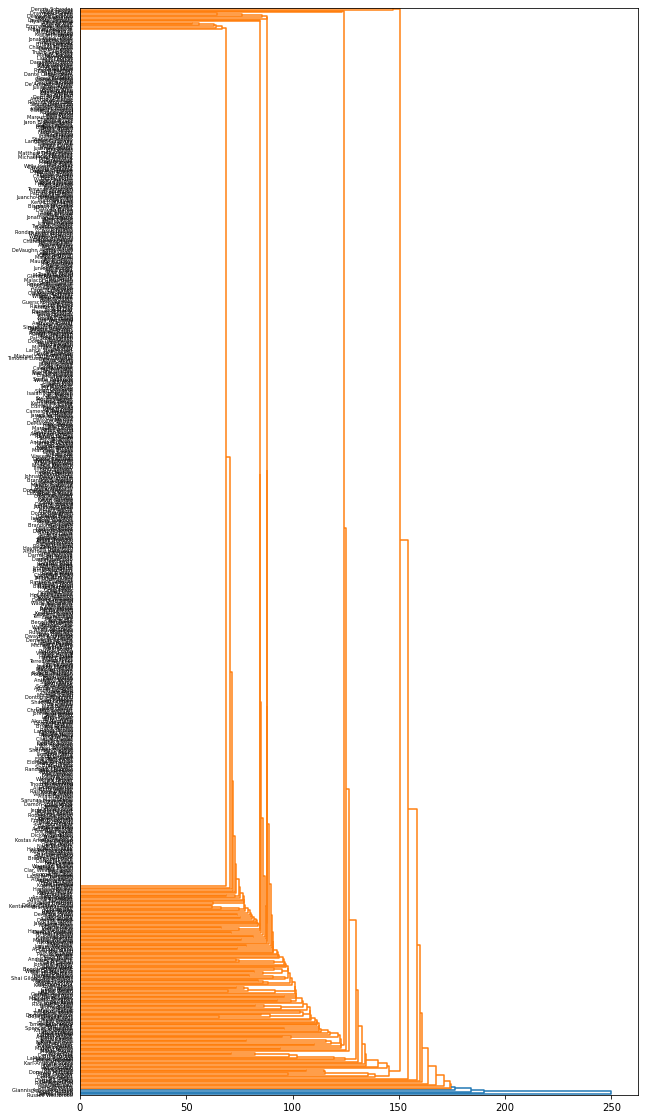

In [51]:
X = ddmat_copy
y = names
plt.figure(figsize=(10,20))
den = hc.dendrogram(hc.linkage(X, method='single'), orientation='right',labels=y)